# LOADING IMAGES

In [ ]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

In [ ]:
def load_and_slice_image(image_path, slice_height, slice_width, num_slices, division=2):
    img = Image.open(image_path)
    width = img.width
    slices = []
    # Only slice if the resized image's width is greater than 600 pixels

    if width > 600:
      # Resize the image to make sure it's at least as large as the desired slice dimensions
      new_size = (max(img.width // division, slice_width), max(img.height // division, slice_height))
      img_resized = img.resize(new_size)
      img_width, img_height = img_resized.size
      if img_width >= slice_width and img_height >= slice_height:
        for _ in range(num_slices):
          x = np.random.randint(0, img_width - slice_width + 1)
          y = np.random.randint(0, img_height - slice_height + 1)
          img_slice = img_resized.crop((x, y, x + slice_width, y + slice_height))
          slices.append(img_slice)
      else:
        slices.append(img_resized)
    return slices

ogólnie to jest stara metoda, której nie chciało mi się już zmieniać i tu nie korzystałam z labels, tylko same slices (all_slices), bo metoda train_datagen.flow_from_directory sama przypisuje labele na podstawie hierarchi folderów (np. damy mu ścieżke do '/content/input/images' w ktorej sa dwa foldery wood, stone to alfabetycznie przypisze stone 0 a wood 1)

In [ ]:
def load_images_with_labels(folder_path, texture_label, slice_height, slice_width, num_slices_per_image, division):
    all_slices = []
    labels = []

    # List all files in the folder
    for filename in os.listdir(folder_path):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Check if the file is an image (e.g., .jpg, .jpeg, .png)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                # Load and slice the image
                slices = load_and_slice_image(file_path, slice_height, slice_width, num_slices_per_image, division)
                # Append the slices to the all_slices list
                all_slices.extend(slices)
                # Append the same label for all slices from the same texture
                labels.extend([texture_label] * len(slices))
            except Exception as e:
                print(f"Cannot identify image file, skipping: {file_path}")

    return all_slices, labels


In [ ]:
def save_slices(slices, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, img_slice in enumerate(slices):
        # Convert image to RGB if it is in grayscale
        if img_slice.mode == 'I':
            img_slice = img_slice.convert('RGB')
        if img_slice.mode == 'RGBA':
          img_slice = img_slice.convert('RGB')
        img_slice.save(os.path.join(output_dir, f'slice_{i}.jpg'))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path_wood = '/content/input/images/wood'
folder_path_stone = '/content/input/images/stone'

In [ ]:
os.makedirs(folder_path_wood)
os.makedirs(folder_path_stone)

In [ ]:
folder_path_w = '/content/drive/MyDrive/images/wood'
folder_path_s = '/content/drive/MyDrive/images/stone'
# folder_path_g = '/content/grass'

slice_height = 256
slice_width = 256
num_slices_per_image = 2

# Load images and labels
wood_slices, wood_labels = load_images_with_labels(folder_path_w, 0, slice_height, slice_width, num_slices_per_image, division=1)
stone_slices, stone_labels = load_images_with_labels(folder_path_s, 1, slice_height, slice_width, num_slices_per_image, division=6)
#grass_slices, grass_labels = load_images_with_labels(folder_path_g, 2, slice_height, slice_width, num_slices_per_image, division=4)

Cannot identify image file, skipping: /content/drive/MyDrive/images/wood/WoodPlanks-0509.jpg
Cannot identify image file, skipping: /content/drive/MyDrive/images/wood/WoodPlanks-0512.jpg


In [ ]:
print(len(wood_slices))
print(len(stone_slices))

2282
1440


In [ ]:
save_slices(wood_slices, folder_path_wood)
save_slices(stone_slices, folder_path_stone)

In [ ]:
def count_items_in_folder(folder_path):
    """Counts the number of files and directories in a given folder."""
    items = os.listdir(folder_path)  # List all files and directories in the folder
    return len(items)  # Return the count of items

# Example usage:
folder_path = folder_path_wood
item_count = count_items_in_folder(folder_path)
print(f"There are {item_count} items in the folder.")

There are 2282 items in the folder.


In [ ]:
import os

def check_file_extensions(folder_path, extensions=('.bmp', '.gif', '.jpeg', '.jpg', '.png')):
    unexpected_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if not file.lower().endswith(extensions):
                unexpected_files.append(os.path.join(root, file))
    return unexpected_files

wrong_files = check_file_extensions(folder_path)
print(f"Files with unexpected extensions: {wrong_files}")


Files with unexpected extensions: []


# CGAN

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, Dense, Flatten, Reshape,
                                     BatchNormalization, LeakyReLU, Embedding, Concatenate, Input, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, Concatenate, Embedding, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import ReLU
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, Embedding, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

In [ ]:
img_width, img_height = 256, 256
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory='/content/input/images',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  # Using binary here since we have two classes; adjust if needed
)

Found 3722 images belonging to 2 classes.


In [ ]:
# Kernel initializer
kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Input dimensions for the generator
latent_dim = 100
num_classes = 2

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               200       ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


                                                                     'flatten[0][0]']             
                                                                                                  
 dense (Dense)               (None, 32768)                6586368   ['concatenate[0][0]']         
                                                                                                  
 re_lu (ReLU)                (None, 32768)                0         ['dense[0][0]']               
                                                                                                  
 reshape (Reshape)           (None, 8, 8, 512)            0         ['re_lu[0][0]']               
                                                                                                  
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)          2097408   ['reshape[0][0]']             
 anspose)                                                                                         
          

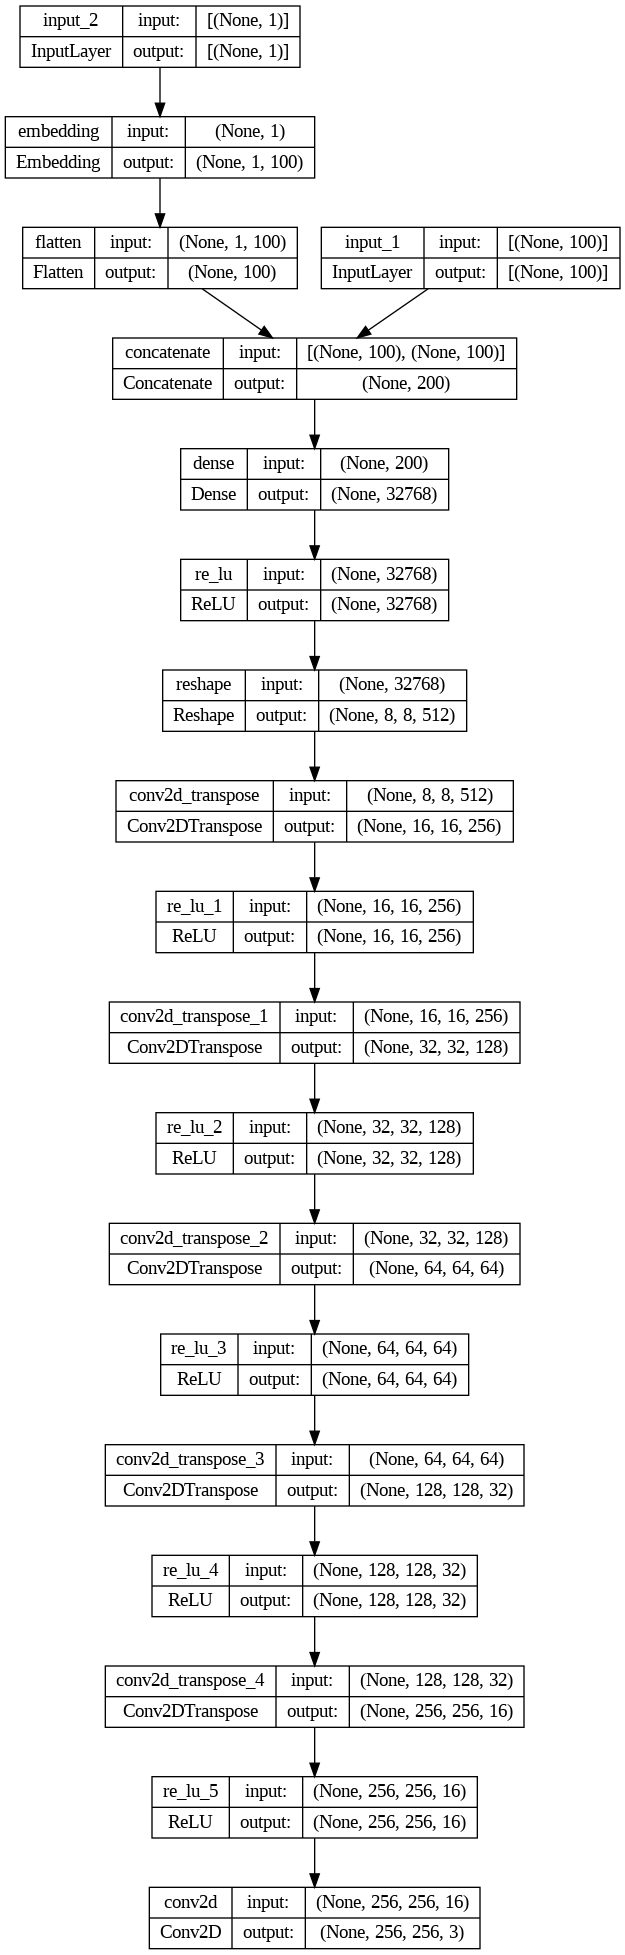

In [ ]:
def build_conditional_generator(latent_dim, num_classes):
    # Noise input
    noise_input = Input(shape=(latent_dim,))

    # Label input
    label_input = Input(shape=(1,), dtype='int32')

    # Embedding for categorical input
    label_embedding = Embedding(num_classes, latent_dim)(label_input)
    label_embedding = Flatten()(label_embedding)

    # Concatenate noise and label embedding
    merged_input = Concatenate()([noise_input, label_embedding])

    # Dense layer
    x = Dense(8*8*512, kernel_initializer=kernel_initializer)(merged_input)
    x = ReLU()(x)

    # Reshape to 8 x 8 x 512
    x = Reshape((8, 8, 512))(x)

    # Transposed convolutions
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
    x = ReLU()(x)
    x = Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', kernel_initializer=kernel_initializer)(x)
    x = ReLU()(x)

    # Output layer
    x = Conv2D(3, (4, 4), padding='same', activation='sigmoid')(x)

    # Define the model
    model = Model([noise_input, label_input], x)
    return model

# Create the generator model
conditional_generator = build_conditional_generator(latent_dim, num_classes)
conditional_generator.summary()  # Print the summary of the model

# Visualize the model structure
tf.keras.utils.plot_model(conditional_generator, show_shapes=True, show_layer_names=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                100       ['input_4[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 1, 65536)             3342336   ['embedding_1[0][0]']         
                                                                                                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                            

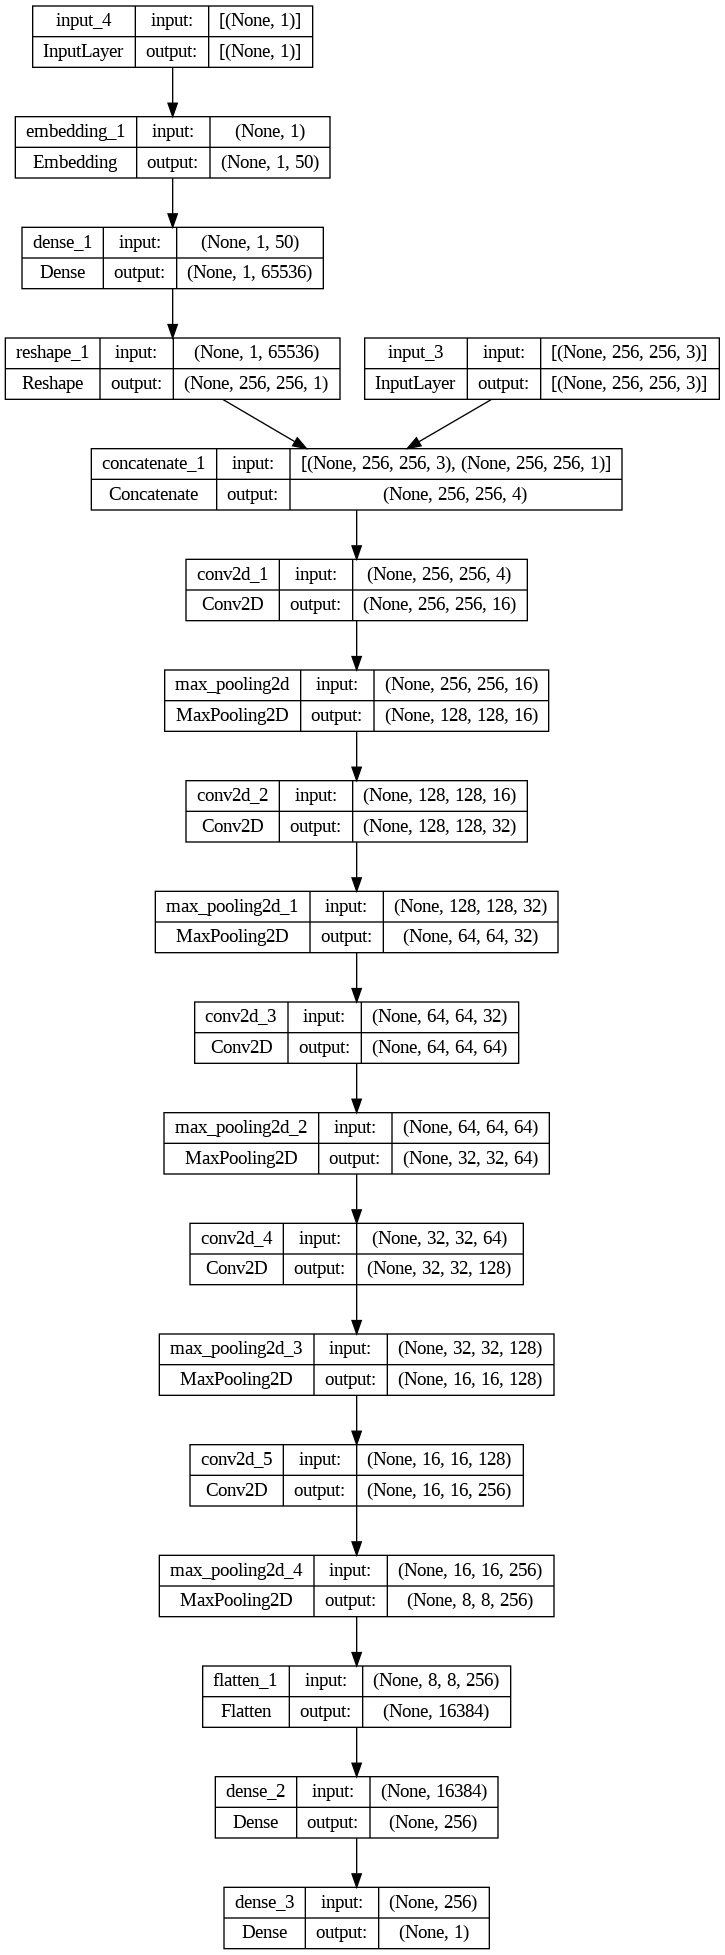

In [ ]:
def build_conditional_discriminator(img_height, img_width, num_classes):
    # Image input
    image_input = Input(shape=(img_height, img_width, 3))

    # Label input
    label_input = Input(shape=(1,), dtype='int32')

    # Embedding for categorical input
    label_embedding = Embedding(num_classes, 50)(label_input)
    # This dense layer expands the embedding to match the image dimensionality
    label_embedding = Dense(img_height * img_width)(label_embedding)
    label_embedding = Reshape((img_height, img_width, 1))(label_embedding)  # Add an extra dimension to match the image's 3D structure

    # Concatenate image and label embeddings
    merged_input = Concatenate()([image_input, label_embedding])

    # Sequential layers of the discriminator with convolutions and pooling
    x = Conv2D(16, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(merged_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(256, kernel_size=(3, 3), padding='same', activation=LeakyReLU(alpha=0.2))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)  # Output probability that the image is real

    # Define the model
    model = Model(inputs=[image_input, label_input], outputs=x)
    return model

# Parameters
img_width, img_height = 256, 256
num_classes = 2

# Create the discriminator model
conditional_discriminator = build_conditional_discriminator(img_height, img_width, num_classes)
conditional_discriminator.summary()  # Print the summary of the model

# Visualize the model structure
tf.keras.utils.plot_model(conditional_discriminator, show_shapes=True, show_layer_names=True)

In [ ]:
class CGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim  # Size of the random noise vector fed into the generator
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data. Each batch consists of real images and their labels
        real_images, labels = data

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # Generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate random labels for generated images
        random_labels = tf.random.uniform(shape=(batch_size, 1), minval=0, maxval=num_classes, dtype=tf.int32)

        # Train the discriminator with both real and fake images
        with tf.GradientTape() as disc_tape:
            # Generate fake images
            fake_images = self.generator([random_noise, random_labels], training=True)

            # Discriminator decision for real and fake images
            real_logits = self.discriminator([real_images, labels], training=True)
            fake_logits = self.discriminator([fake_images, random_labels], training=True)

            # Calculate the discriminator loss using real and fake images
            d_real_loss = self.loss_fn(tf.ones_like(real_logits), real_logits)
            d_fake_loss = self.loss_fn(tf.zeros_like(fake_logits), fake_logits)
            d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate gradients for discriminator
        d_gradients = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train the generator (do not update discriminator weights)
        with tf.GradientTape() as gen_tape:
            # Generate fake images
            fake_images = self.generator([random_noise, random_labels], training=True)
            # Discriminator decision on the fake images
            fake_logits = self.discriminator([fake_images, random_labels], training=True)

            # Calculate the generator loss
            g_loss = self.loss_fn(tf.ones_like(fake_logits), fake_logits)

        # Calculate gradients for generator
        g_gradients = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

# Model instantiation and compilation
latent_dim = 100
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = Adam(learning_rate=0.0001, beta_1=0.5) # discriminator learning rate lower to avoid divergence
loss_fn = BinaryCrossentropy(from_logits=True)

cgan = CGAN(generator=conditional_generator, discriminator=conditional_discriminator, latent_dim=latent_dim)
cgan.compile(g_optimizer=g_optimizer, d_optimizer=d_optimizer, loss_fn=loss_fn)


In [ ]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=conditional_generator,
                                 discriminator=conditional_discriminator)

In [ ]:
class CGANMonitor(keras.callbacks.Callback):
    """
    The CGANMonitor class is a custom callback for Keras that is used to monitor the progress of a Conditional
    Generative Adversarial Network (cGAN) during training. It generates images conditioned on specific labels
    to visually assess how well the generator is improving over time.
    """
    def __init__(self, num_imgs=25, latent_dim=100, num_classes=2):
        self.num_imgs = num_imgs  # Number of images to generate for monitoring purposes.
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        # Create random noise and labels for generating images
        self.noise = tf.random.normal([num_imgs, latent_dim])
        # Generate fixed labels (e.g., 0, 1 for two classes) for visualization during training
        self.labels = tf.range(0, num_classes)
        self.labels = tf.repeat(self.labels, num_imgs // num_classes)

    def on_train_end(self, logs=None):
        # Save the generator and discriminator models at the end of training
        self.model.generator.save('CGEN.h5')
        self.model.discriminator.save('CDISC.h5')



In [ ]:
# Set up the log directory for TensorBoard logs
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
epochs = 100

# Fit the model and save the history
history = cgan.fit(
    train_generator,
    epochs=epochs,
    callbacks=[CGANMonitor(), tensorboard_callback]
)

Epoch 1/100
117/117 [==============================] - 35s 301ms/step - d_loss: 0.5251 - g_loss: 1.2095
Epoch 2/100
117/117 [==============================] - 34s 292ms/step - d_loss: 0.5085 - g_loss: 1.2351
Epoch 3/100
117/117 [==============================] - 34s 288ms/step - d_loss: 0.5337 - g_loss: 1.2043
Epoch 4/100
117/117 [==============================] - 35s 298ms/step - d_loss: 0.5595 - g_loss: 1.0546
Epoch 5/100
117/117 [==============================] - 34s 288ms/step - d_loss: 0.5407 - g_loss: 1.1816
Epoch 6/100
117/117 [==============================] - 35s 301ms/step - d_loss: 0.5426 - g_loss: 1.2025
Epoch 7/100
117/117 [==============================] - 34s 291ms/step - d_loss: 0.5567 - g_loss: 1.1809
Epoch 8/100
117/117 [==============================] - 36s 305ms/step - d_loss: 0.5302 - g_loss: 1.1654
Epoch 9/100
117/117 [==============================] - 34s 291ms/step - d_loss: 0.5423 - g_loss: 1.3295
Epoch 10/100
117/117 [==============================] - 34s 290m

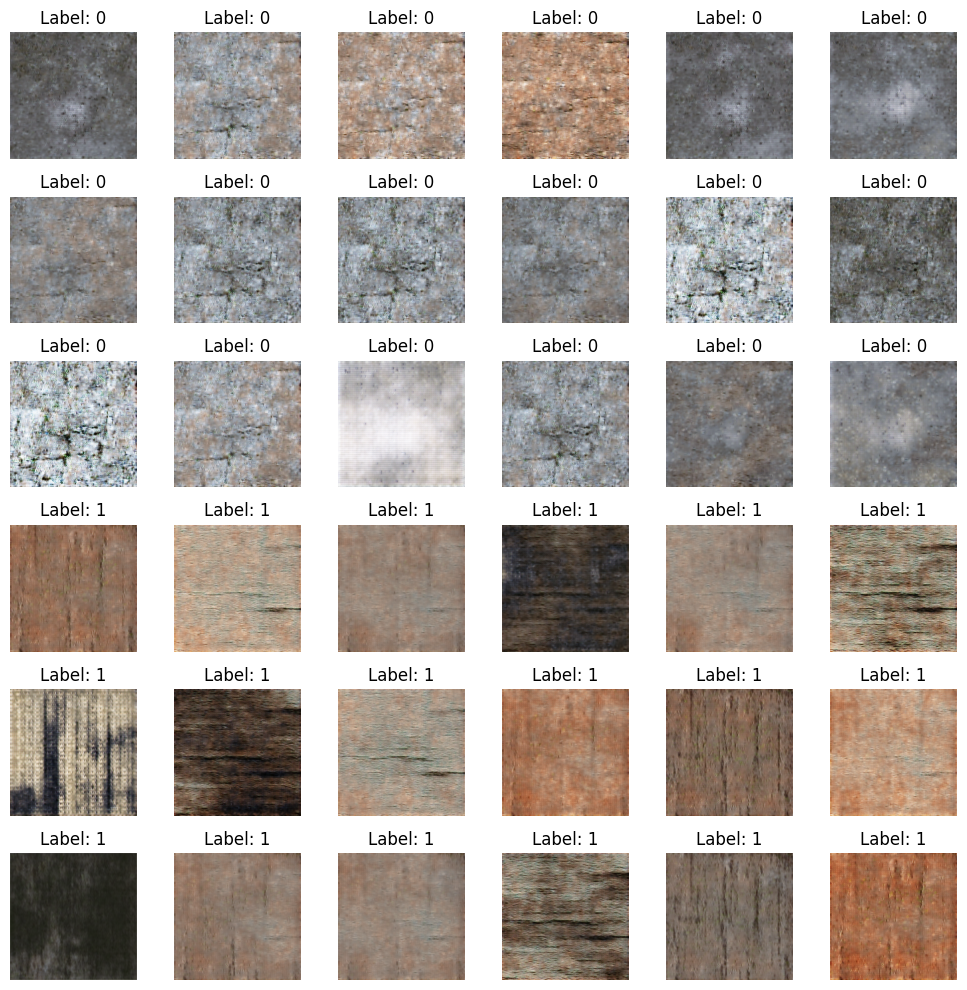

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained generator model if it's not already loaded
generator = load_model('CGEN.h5')

# Set parameters
num_images = 36  # Total number of images
labels_per_class = num_images // 2  # Images per class
latent_dim = 100  # Dimensionality of the input noise vector

# Prepare noise and labels
noise = tf.random.normal([num_images, latent_dim])

# Create labels for each class (0 and 1)
labels = tf.concat([
    tf.zeros((labels_per_class, 1), dtype=tf.int32),  # Labels for class 0
    tf.ones((labels_per_class, 1), dtype=tf.int32)   # Labels for class 1
], axis=0)

# Generate images from the noise and labels
generated_images = cgan.generator([noise, labels], training=False)
# generated_images = (generated_images * 127.5 + 127.5).numpy()  # Rescale the images to the 0-255 range
generated_images = (generated_images * 255).numpy()

# Plotting the generated images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(6, 6, i + 1)
    image = np.uint8(generated_images[i])
    plt.imshow(image)
    plt.title(f"Label: {labels[i, 0].numpy()}")
    plt.axis('off')

plt.tight_layout()
plt.show()
